# Lab 3 — recommender systems

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

from operator import itemgetter
import pickle

%matplotlib inline
plt.style.use("ggplot")

What does the data look like?

In [2]:
!hdfs dfs -cat /ix/ml-20m/ratings.txt | tail -n 2

{"movieId": 70286, "userId": 138493, "timestamp": 1258126944, "rating": 5.0}
{"movieId": 71619, "userId": 138493, "timestamp": 1255811136, "rating": 2.5}


In [3]:
data = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)

## Exercise 3.4 - Basic statistics

First, we will look at basic statistics on this dataset.


#### Getting data

In [4]:
from pyspark.sql import SQLContext, Row, functions
ratings_DF = data.map(lambda l: Row(**dict(l))).toDF()

In [5]:
ratings_per_user=ratings_DF.groupBy('userId').agg(functions.collect_list('movieId'),functions.collect_list('timestamp'),functions.collect_list('rating'))
ratings_per_movie=ratings_DF.groupBy('movieId').agg(functions.collect_list('userId'),functions.collect_list('timestamp'),functions.collect_list('rating'))

In [6]:
print("Amount users: ",ratings_per_user.count())
print("Amount movies ",ratings_per_movie.count())

Amount users:  138493
Amount movies  26744


In [7]:
user_ratings=ratings_per_user.collect()

user_counts=[]

#count how many ratings for each user
for row in user_ratings:
    user_counts.append(len(row[3]))

user_counts=sorted(user_counts)

In [8]:
movie_ratings=ratings_per_movie.collect()

movie_counts=[]

#count how many ratings for each movie
for row in movie_ratings:
    movie_counts.append(len(row[3]))

movie_counts=sorted(movie_counts)

#### Plots


* Plot the number of ratings for each user.
* Plot the number of ratings for each item.

Is the number of ratings balanced uniformly across users and movies?


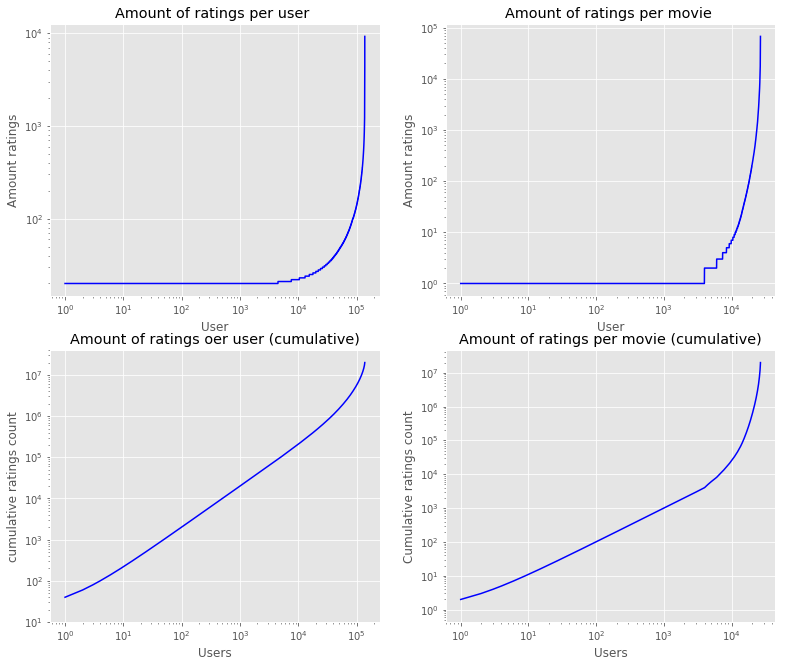

In [9]:
u_cum = np.cumsum(user_counts)
m_cum = np.cumsum(movie_counts)

fig, ((ax3, ax4),( ax1 , ax2)) = plt.subplots(ncols=2,nrows=2,figsize=(13, 11))

ax1.plot(u_cum,color="blue")
ax1.set_title("Amount of ratings oer user (cumulative)")
ax1.set_xlabel('Users')
ax1.set_ylabel('cumulative ratings count')

ax2.plot(m_cum,color="blue")
ax2.set_title("Amount of ratings per movie (cumulative)")
ax2.set_xlabel('Users')
ax2.set_ylabel('Cumulative ratings count')

ax3.plot(user_counts,color="blue")
ax3.set_title("Amount of ratings per user ")
ax3.set_xlabel('User')
ax3.set_ylabel('Amount ratings')

ax4.plot(movie_counts,color="blue")
ax4.set_title("Amount of ratings per movie ")
ax4.set_xlabel('User')
ax4.set_ylabel('Amount ratings')

ax2.loglog()
ax1.loglog()
ax3.loglog()
ax4.loglog()

plt.show()

As seen in the graphs the ratings across movies and users follow a power law distribution. So we have a long tail of users that have only rated a few movies and only a few users have rated a lot of movies. Similarly there are many movies with few ratings and only a few with a lot.

---
## Exercise 3.5 - Partitioning the dataset

In order to tune hyperparameters and evaluate the recommender system’s performance, we will split the data into a trainin and a validation set.

* Append your personal ratings to the MovieLens dataset RDD.

In [10]:
#run my_ratings.py first
with open('my-ratings.txt') as f:
    my_ratings = sc.parallelize([json.loads(line) for line in f.read().splitlines()])
    
#add my rating    
data_full = data.union(my_ratings)

* Partition the data into two sets: 80% for training, and 20% for validation.

Hint: A convenient way to split the data is to filter on the last digit of the rating’s timestamp

In [11]:
#filter on last digit: take modulu 10, if 0 or 1 -> test set, rest training set
training_set = data_full.filter(lambda x: (x['timestamp'] % 10) > 1).map(lambda x: (x['userId'], x['movieId'], x['rating']))
test_set = data_full.filter(lambda x: (x['timestamp'] % 10) <= 1).map(lambda x: (x['userId'], x['movieId'], x['rating']))

In [12]:
#check that distribution is correct
train_count = training_set.count()
test_count=test_set.count()
print("Length traing set: ",train_count)
print("Length test set: ",test_count)
print("Data percentage of traing set: ",100*train_count/(train_count+test_count),"%")
print("Data percentage of traing set: ",100*test_count/(train_count+test_count),"%")

Length traing set:  15999979
Length test set:  4000290
Data percentage of traing set:  79.99881901588424 %
Data percentage of traing set:  20.001180984115763 %


---
# Baseline recommender system


## Exercise 3.6 - Baseline model

You will first implement a recommender system based on model (3.1).

* Compute the global mean μ, the user biases $ \{ α_{u} \}$  and the item biases  $ \{ β_{m} \}$ using a sequence of RDD transformations on the training set.



In [13]:
#get mean over all ratings, third entry in the array
mean = training_set.map(lambda x: x[2]).mean()

In [14]:
mean

3.525507595978725

In [15]:
training_set.take(3)

[(1, 2, 3.5), (1, 29, 3.5), (1, 32, 3.5)]

In [16]:
#get biases for each key
# this function gets rdd (key,value) and returns dict with {key: mean for the given key}
# inspired by: http://stackoverflow.com/questions/29930110/calculating-the-averages-for-each-key-in-a-pairwise-k-v-rdd-in-spark-with-pyth

def mean_per_key(rdd):

    return (rdd.aggregateByKey((0,0), lambda a,b: (a[0] + b,    a[1] + 1),
                                       lambda a,b: (a[0] + b[0], a[1] + b[1]))).mapValues(lambda v: v[0]/v[1]).collectAsMap()

In [17]:
#trainig set is (user,movie,rating)
#get(user,rating-mean) 
temp=training_set.map(lambda x: (x[0], x[2] - mean))
#compute mean for each user in (user,rating-mean), which will be the biases
user_biases = mean_per_key(temp)

In [18]:
#get(movie,rating-user_bias- mean) 
temp=training_set.map(lambda x: (x[1], x[2] - user_biases[x[0]] - mean))
#compute mean for each user in (user,rating-mean), which will be the biases
movie_biases = mean_per_key(temp)

In [21]:
#checking that amount users in training set fits user_biases
a=training_set.countByKey()

In [24]:
len(a)==len(user_biases)

True

* How many parameters does this model have?

As stated in the slides, Recommender Systems 1 slide 12, we have n+m parameters. In our case:

In [25]:
print ("n: ", len(movie_biases))
print ("m: ",len(user_biases))
print("total amount of parameters, n+m: ",len(user_biases)+len(movie_biases))

n:  25868
m:  138458
total amount of parameters, n+m:  164326


* Predict the rating of every user / movie pair in the validation set.

Note: some users / movies do not have any ratings. Use sensible default values for
$ \{ α_{u} \}$  and $ \{ β_{m} \}$. We are going to use the mean over all biases


In [26]:
#get mean over user and movie biases
user_bias_mean=np.mean([user_biases[k] for k in user_biases])
movie_bias_mean=np.mean([movie_biases[k] for k in movie_biases])

In [27]:
#use mean as default if key does not exist in dictionary
def predict_single(userId, movieId):
    return ((userId, movieId), mean + user_biases.get(userId,user_bias_mean) + movie_biases.get(movieId,movie_bias_mean))

def predict(data_set):
    to_be_predicted=data_set.map(lambda x: (x[0], x[1]))
    return to_be_predicted.map(lambda x: predict_single(x[0], x[1]))

In [28]:
predictions=predict(test_set)

In [29]:
predictions.first()
#user 1 movie 50 predicted rating 4.46

((1, 50), 4.467954194198163)

---
## Exercise 3.7 - Evaluation

Compute RMSE

In [30]:
from math import sqrt
from operator import add

def RMSE(pred):

    #join predictions with the eactual rating from the test set
    rating_vs_predictions = test_set.map(lambda x: ((x[0], x[1]), x[2])).join(pred)
    #print(rating_vs_predictions.first())
    
    #get difference for all user and square it
    squared_difference=rating_vs_predictions.map(lambda x: (x[0][0], (x[1][0] - x[1][1]) ** 2))
    
    #take mean of the difference the differences for each user --- in the formula this is under the square root
    user_mean= (squared_difference.aggregateByKey((0,0), lambda a,b: (a[0] + b,    a[1] + 1),
                                       lambda a,b: (a[0] + b[0], a[1] + b[1]))).mapValues(lambda v: v[0]/v[1])
    
    #take squareroot of each user's difference and then the mean (same as dividing by U)
    return user_mean.map(lambda x: np.sqrt(x[1])).mean()

In [31]:
print("RMSE = ",RMSE(predictions))

RMSE =  0.868364450938


---
# Matrix-factorization model

## Exercise 3.8 Regularization

Decide on a rank for your model, e.g., between 5 and 25. What is the trade-off between choosing a lower and a higher rank?

* Set the regularization parameter lambda_ to 10−4. How accurate are the predicted ratings? Can you explain the phenomenon?
*  Now set `lambda_` to 10.0. What happens to the predicted ratings, and why?
* Find the value of `lambda_` that minimizes the validation error.

What improvement do you get over the error of the baseline recommender system?

In [32]:
from pyspark.mllib.recommendation import ALS

* Decide on a rank for your model, e.g., between 5 and 25. What is the trade-off between choosing a lower and a higher rank?

The rank denotes the amount of the model's latent factors. Latent factors are the model's parameters that we have to train. The more latent factors there are the more complex the model. So with low rank the model is simple and thus training will be quicker. A higher rank on the other hand creates a model with higher dimension which leads to more flexibility and thus better fit to the training set. The added flexibility of the model can quickly lead to overfitting, though.


We choose a model of rank 10.

In [33]:
rank = 10

---
#### Prediction method

In [34]:
#method predicts using als and given lambda_ and return error
def predict_and_evaluate(lambda_):
    model= ALS.train(training_set, rank, lambda_=lambda_)
    preds= model.predictAll(test_set.map(lambda x: (x[0], x[1]))).map(lambda x: ((x[0], x[1]), x[2]))
    error=RMSE(preds)
    return error


---
* Set the regularization parameter lambda_ to $10^{-4}$. How accurate are the predicted ratings? Can you explain the phenomenon?

In [35]:
lambda_1 = 10**(-4)
error_1= predict_and_evaluate(lambda_1)
print("RMSE for lambda_= 10e-4: ",error_1)

RMSE for lambda_= 10e-4:  0.901463950565


This model perfomes a little bit worse than the baseline model in section 3.6/3.7.

`lambda_` specifies the regularization parameter in ALS. The regularization is supposed to penalize complexity of a model and favor simplicity which is supposed to prevent overfitting. The bigger `lambda_` is the more regularization is done.

As this model is not performing better than the baseline model one can conlude that the parameter is probably too small and does not penalize the model's complexity enough. Probably this model is still overfitting and thus worse than the baseline model.



* Now set `lambda_` to 10.0. What happens to the predicted ratings, and why?

In [36]:
lambda_2=10.0
error_2= predict_and_evaluate(lambda_2)
print("RMSE for lambda_= 10: ",error_2)

RMSE for lambda_= 10:  3.74687983336


The loss is way too big which shows that the `lambda_` is too big, too. That leads to the model being too simple and not being able to fit the data well.

* Find the value of `lambda_` that minimizes the validation error.

The best `lambda_` is probably between 10e-4 and 10.

In [37]:
#try these lambdas
lambdas=[0.001,0.01,0.1,1.0]
#save all errors
errors = []

for lambda_ in lambdas:

    errors.append(predict_and_evaluate(lambda_))


In [38]:
#list errors
print("Listing errors of prediction models with different lambdas:")
for i,v in enumerate(errors):
    print("lambda_=",lambdas[i],": ",v)

Listing errors of prediction models with different lambdas:
lambda_= 0.001 :  0.853786767134
lambda_= 0.01 :  0.835391872761
lambda_= 0.1 :  0.808002117119
lambda_= 1.0 :  1.33495019244


The best value seems to be `lambda_ = 0.1`

* What improvement do you get over the error of the baseline recommender system?


In [39]:
baseline_loss=0.868364450938

#get imporovement
diff = baseline_loss - errors[2]
improvement = 100* diff / baseline_loss 

print ("The model with lambda_=0.1 achives a loss improvement of ",improvement,"% over the baseline model")

The model with lambda_=0.1 achives a loss improvement of  6.95126726501 % over the baseline model


---
## Exercise 3.9 - Recommendation


Create a Python dict that maps from movie IDs to movie titles based on the file `movies.txt`.


In [40]:
movies = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
movie2title = movies.map(itemgetter("movieId", "title")).collectAsMap()

* Recommend 10 movies for user 123 using model.recommendProducts(). What kind of movies does the model think the user will like?

In [41]:
#recommend the too n best rated movies for given user id
def recommend(userId, top_n, model):
    #get recommendations from model
    recomendations = model.recommendProducts(userId, top_n)
    #returns smth like  [Rating(user=1, product=2, rating=1.9...), Rating(user=1, product=1, rating=1.0...)...
    #get movie_id (movie in this case "product") for each recommendation
    movie_ids = [rating[1] for rating in recomendations]
    movies = [movie2title[movie] for movie in movie_ids]
    return movies

In [42]:
#create rdd dataset of all data, my ratings including, in right format for training
dataset= data_full.map(lambda x: (x['userId'], x['movieId'], x['rating']))

#train the model with all data and best parameters
model= ALS.train(dataset, 10, lambda_=0.1)

In [43]:
recommend(123,10,model)    

['Marihuana (1936)',
 'Peppermint Soda (Diabolo menthe) (1977)',
 'My Brother Tom (2001)',
 'Bill Hicks: Sane Man (1989)',
 'Plastic Bag (2009)',
 'Moth, The (Cma) (1980)',
 'Flight of the Conchords: A Texan Odyssey (2006)',
 'Island at War (2004)',
 'Diplomatic Immunity (2009– )',
 'No Distance Left to Run (2010)']

I do not know the movies, but after consulting Google it seems like those are mainly dramas recommended, a little comedy like Bill Hicks and Diplomatic Immunity and a documentary.

* Recommend 10 movies to yourself (user ID: 138494)

In [44]:
#recommend for me
recommend(138494, 10,model)

['Marihuana (1936)',
 'Willie & Phil (1980)',
 'No Distance Left to Run (2010)',
 'Code Name Coq Rouge (1989)',
 'Island at War (2004)',
 'Diplomatic Immunity (2009– )',
 'From Dad to Son (2012)',
 'Lascars (2009)',
 'The Bloody Olive (1997)',
 'Homeboy (1988)']

* What do you think of your recommendations? :-)

First of all, I do not know any of those movies which is already a bad sign because I would have expected at leats some recommendations of movies I have watched and liked but not rated in the system. 

The recommendation seems to be more in the direction of comedy/Drama and some movies are even the same as with user 123 (which is weird). It does not fit my liking. The movies I have googled did not seem interesting (I have not watched them though, so who knows). Unless the recommendation system knows me better than myself (which it does not) it does not give very good recommendations, unfortunately.

---
## Exercise 3.10 - Visualization

Learn a rank-2 matrix-factorization model using ALS().


In [45]:
#using rank 2 and lambda 0.1
model = ALS.train(dataset, rank=2, lambda_=0.1)

*  Extract the features for all the movies in selected-movies.pickle.

In [46]:
selected_movies = sorted(pickle.load(open('selected-movies.pickle', 'rb'), encoding='utf-8'))
selected_movies

[(260, 'Star Wars: Episode IV - A New Hope (1977)', 0.93),
 (318, 'Shawshank Redemption, The (1994)', 0.91),
 (356, 'Forrest Gump (1994)', 0.72),
 (480, 'Jurassic Park (1993)', 0.93),
 (527, "Schindler's List (1993)", 0.96),
 (780, 'Independence Day (a.k.a. ID4) (1996)', 0.6),
 (805, 'Time to Kill, A (1996)', 0.67),
 (1199, 'Brazil (1985)', 0.98),
 (1240, 'Terminator, The (1984)', 1.0),
 (2324, 'Life Is Beautiful (La Vita è bella) (1997)', 0.8),
 (2329, 'American History X (1998)', 0.83),
 (2571, 'Matrix, The (1999)', 0.87),
 (2706, 'American Pie (1999)', 0.6),
 (2858, 'American Beauty (1999)', 0.88),
 (2959, 'Fight Club (1999)', 0.79),
 (3967, 'Billy Elliot (2000)', 0.85),
 (4465, 'Accused, The (1988)', 0.95),
 (4658, 'Santa Sangre (1989)', 0.85),
 (4700, 'Princess Diaries, The (2001)', 0.47),
 (5147, 'Wild Strawberries (Smultronstället) (1957)', 0.95),
 (5163, 'Stage Fright (Deliria) (1987)', 0.68),
 (5349, 'Spider-Man (2002)', 0.89),
 (5687, 'Take Care of My Cat (Goyangileul butagha

* Create an interactive plot that embeds the movies along the 2 directions defined by the factorization.

In [47]:
features = model.productFeatures()

In [48]:
#get the ids
selected_ids = [movie[0] for movie in selected_movies]
#get only features of selected ids
selected_features = sorted(features.filter(lambda x: x[0] in selected_ids).collect())
                           
names = [x[1] for x in sorted(selected_movies)]
ratings = [x[2] for x in sorted(selected_movies)]
features = np.asarray([x[1] for x in selected_features])

In [50]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
import matplotlib as mpl
from bokeh.io import push_notebook, show, output_notebook
from bokeh.models import HoverTool
output_notebook()


output_file("selected_ratings.html")

source = ColumnDataSource(
        data={
            "x":features[:,0],
            "y":features[:,1],
            "desc":names,
            "rating":ratings,
            #color depending on rating red, bad , green good
            "color":[
    "#%02x%02x%02x" % (255-int(r), int(g), 0) for r, g, b, _ in 255*mpl.cm.viridis(mpl.colors.Normalize()(ratings))
]
        }
    )

hover = HoverTool(
        tooltips=[
            ("index", " $index"),
            ("(x,y)", " ($x, $y)"),
            ("Name", " @desc"),
            ("Rating", " @rating"),
        ]
    )

p = figure(plot_width=400, plot_height=400, tools=[hover],
           title="Visualization of selected movies")
p.xaxis.axis_label = 'First Principal Component'
p.yaxis.axis_label = 'Second Principal Component'

p.circle(x='x',y= 'y', fill_alpha=0.2, color="color", size=10, source=source)

show(p)

Loading BokehJS ...

* Describe what you observe. Can you give a name to the dimensions? Do you recognize cluster of movies that are alike?

We can see that best rated movies are distributed around the lower right of the graph while movies with worse ratings are dirstributed in the upper left corner. There is a cluster of similar movies on the right, in the middle of the graph, with movies like The Terminator, Edge of Tomorrow, The Matrix, The Accused. All Action/SciFi movies. Only Billi Elliot does not really fit in that cluster. in the low right corner we have a cluster of good rated drama movies. So we can conclude that the second component probably denotes the seriousness of a movie going from dramatic/deep (low) to silly (high) , silly movie beig e.g. Just My Luck. The first principal component seems to (maybe not directly) be connected to the rating of the movie as ratings go roughly from left (bad) to right (good)